# Lecture 16 – Data 100, Fall 2024

Data 100, Fall 2024

[Acknowledgments Page](https://ds100.org/fa24/acks/)

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In this lecture, we will work with the `vehicles` dataset.

In [2]:
vehicles = sns.load_dataset("mpg").rename(columns={"horsepower":"hp"}).dropna().sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


We will attempt to predict a car's `"mpg"` from transformations of its `"hp"`.

In [3]:
X = vehicles[["hp"]]
X["hp^2"] = vehicles["hp"]**2
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

Y = vehicles["mpg"]

## Test Sets

To perform a train-test split, we can use the `train_test_split` function of the `sklearn.model_selection` module.

In [4]:
from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=100, 
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points


We then fit the model using the training set...

In [5]:
import sklearn.linear_model as lm

model = lm.LinearRegression()

model.fit(X_train, Y_train)

LinearRegression()

...and evaluate its performance by making predictions on the test set. Notice that the model performs more poorly on the test data it did not encounter during training.

In [6]:
from sklearn.metrics import mean_squared_error

train_error = mean_squared_error(Y_train, model.predict(X_train))
test_error = mean_squared_error(Y_test, model.predict(X_test))

print(f"Training error: {train_error}")
print(f"Test error: {test_error}")

Training error: 18.341673554878263
Test error: 21.527475812709753


## Validation Sets

To assess model performance on unseen data, then *use* this information to finetune the model, we introduce a validation set. You can imagine this as us splitting the training set into a validation set and a "mini" training set.

In [7]:
# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)

print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


In the cell below, we repeat the experiment from Lecture 14: fit several models of increasing complexity, then compute their errors. Here, we find the model's errors on the **validation set** to understand how model complexity influences performance on unseen data.

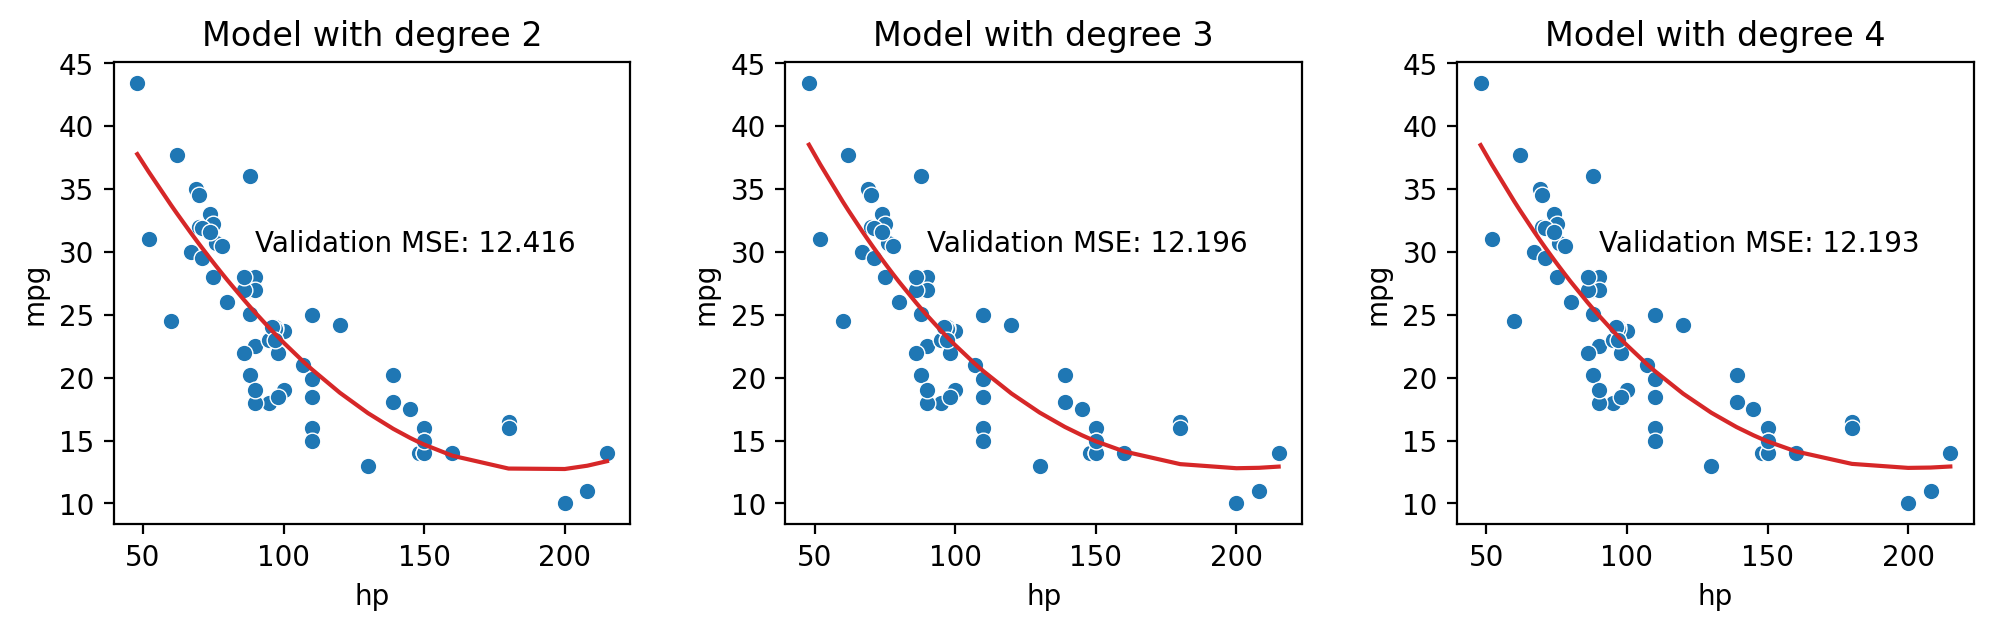

In [8]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for order in [2, 3, 4]:
    model = lm.LinearRegression()
    model.fit(X_train_mini.iloc[:, :order], Y_train_mini)
    val_predictions = model.predict(X_val.iloc[:, :order])
    
    output = X_val.iloc[:, :order]
    output["y_hat"] = val_predictions
    output = output.sort_values("hp")
    
    ax[order-2].scatter(X_val["hp"], Y_val, edgecolor="white", lw=0.5)
    ax[order-2].plot(output["hp"], output["y_hat"], "tab:red")
    ax[order-2].set_title(f"Model with degree {order}")
    ax[order-2].set_xlabel("hp")
    ax[order-2].set_ylabel("mpg")
    ax[order-2].annotate(f"Validation MSE: {np.round(mean_squared_error(Y_val, val_predictions), 3)}", (90, 30))

plt.subplots_adjust(wspace=0.3);

Let's repeat this process:

1. Fit an degree-x model to the mini training set
2. Evaluate the fitted model's MSE when making predictions on the validation set

We use the model's performance on the validation set as a guide to selecting the best combination of features. We are not limited in the number of times we use the validation set – we just never use this set to fit the model.

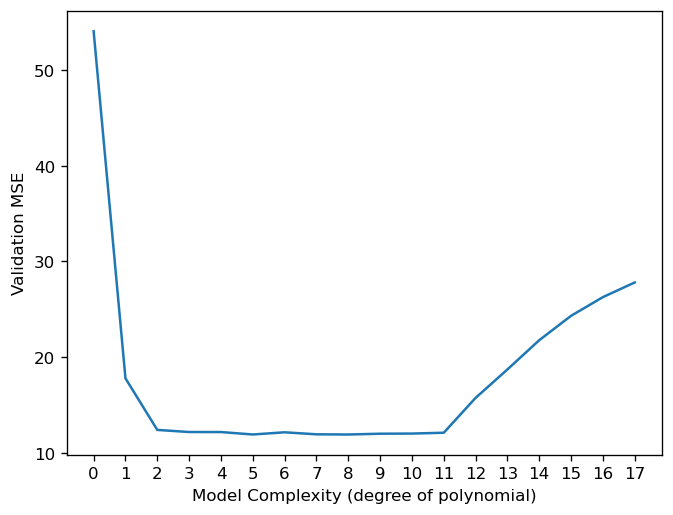

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())    
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    return mean_squared_error(Y_val, pipelined_model.predict(X_val[["hp"]]))

errors = [fit_model_dataset(degree) for degree in range(0, 18)]
MSEs_and_k = pd.DataFrame({"k": range(0, 18), "MSE": errors})

plt.figure(dpi=120)
plt.plot(range(0, 18), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Validation MSE")
plt.xticks(range(0, 18));

In [10]:
MSEs_and_k.rename(columns={"k":"Degree"}).set_index("Degree")

,MSE
Degree,
0,54.024495
1,17.798108
2,12.415902
3,12.196206
4,12.192597
5,11.938336
6,12.166361
7,11.955909
8,11.936340


From this **model selection** process, we might choose to create a model with degree 8.

In [11]:
print(f'Polynomial degree with lowest validation error: {MSEs_and_k.sort_values("MSE").head(1)["k"].values}')

Polynomial degree with lowest validation error: [8]


After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance on the test set. We typically use the entire training set (both the "mini" training set and validation set) to fit the final model.

In [12]:
# Update our training and test sets to include all polynomial features between 5 and 9
for degree in range(5, 9):
    X_train[f"hp^{degree}"] = X_train["hp"]**degree
    X_test[f"hp^{degree}"] = X_test["hp"]**degree

final_model = lm.LinearRegression()
final_model.fit(X_train, Y_train)

print(f"Test MSE of final model: {mean_squared_error(Y_test, final_model.predict(X_test))}")

Test MSE of final model: 20.808784544347933


## Cross-Validation

The validation set gave us an opportunity to understand how the model performs on a **single** set of unseen data. The specific validation set we drew was fixed – we used the same validation points every time.

It's possible that we may have, by random chance, selected a set of validation points that was *not* representative of other unseen data that the model might encounter (for example, if we happened to have selected all outlying data points for the validation set).

Different train/validation splits lead to different validation errors:

In [13]:
for i in range(1, 4):
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
    model = lm.LinearRegression()
    model.fit(X_train_mini, Y_train_mini)
    y_hat = model.predict(X_val)
    print(f"Val error from train/validation split #{i}: {mean_squared_error(y_hat, Y_val)}")

Val error from train/validation split #1: 26.588977267552742
Val error from train/validation split #2: 13.82979524997558
Val error from train/validation split #3: 23.55601096124312


To apply cross-validation, we use the `KFold` class of `sklearn.model_selection`. `KFold` will return the indices of each cross-validation fold. Then, we iterate over each of these folds to designate it as the validation set, while training the model on the remaining folds.

In [14]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook

# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)
validation_errors = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    model.fit(split_X_train, split_Y_train)

    error = mean_squared_error(model.predict(split_X_valid), split_Y_valid)

    validation_errors.append(error)

print(f"Cross-validation error: {np.mean(validation_errors)}")

Cross-validation error: 19.19602744712583


## Regularization

### L1 (LASSO) Regularization

To apply L1 regularization, we use the `Lasso` model class of `sklearn`. `Lasso` functions just like `LinearRegression`. The difference is that now the model will apply a *regularization penalty*. We specify the strength of regularization using the `alpha` parameter, which is equivalent to $\frac{1}{\lambda}$ from our objective function formulation.

In [15]:
import sklearn.linear_model as lm

lasso_model = lm.Lasso(alpha=0.1) # In sklearn, alpha represents the lambda hyperparameter
lasso_model.fit(X_train, Y_train) 

lasso_model.coef_

array([-5.14100640e-01,  1.16422594e-03,  2.70209864e-06, -8.05153574e-10,
       -2.78280269e-11, -1.02040718e-13, -5.44295812e-17,  1.83589942e-18])

To increase the strength of regularization (decrease model complexity), we increase the $\lambda$ hyperparameter by changing `alpha`.

In [16]:
lasso_model_large_lambda = lm.Lasso(alpha=10)
lasso_model_large_lambda.fit(X_train, Y_train) 

lasso_model_large_lambda.coef_

array([-0.00000000e+00, -3.37446532e-03,  1.31817186e-05,  1.71062658e-08,
       -2.44893438e-11, -2.11314339e-13, -5.38994214e-16,  7.05457777e-19])

Notice that these model coefficients are very small (some are effectively 0). This reflects L1 regularization's tendency to set the parameters of unimportant features to 0. We can use this in **feature selection**.

The features in our dataset are on wildly different numerical scales. To see this, compare the values of `hp` to the values of `hp^8`.

In [17]:
X_train.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
72,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
89,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
92,158.0,24964.0,3944312.0,6.232013e+08,9.846580e+10,1.555760e+13,2.458100e+15,3.883799e+17
124,180.0,32400.0,5832000.0,1.049760e+09,1.889568e+11,3.401222e+13,6.122200e+15,1.101996e+18
88,137.0,18769.0,2571353.0,3.522754e+08,4.826172e+10,6.611856e+12,9.058243e+14,1.240979e+17


In order for the feature `hp` to contribute in any meaningful way to the model, LASSO is "forced" to allocate disproportionately much of its parameter "budget" towards assigning a large value to the model parameter for `hp`. Notice how the parameter for `hp` is much, much greater in magnitude than the parameter for `hp^8`.

In [18]:
pd.DataFrame({"Feature":X_train.columns, "Parameter":lasso_model.coef_})

,Feature,Parameter
0,hp,-5.141006e-01
1,hp^2,1.164226e-03
2,hp^3,2.702099e-06
3,hp^4,-8.051536e-10
4,hp^5,-2.782803e-11
5,hp^6,-1.020407e-13
6,hp^7,-5.442958e-17
7,hp^8,1.835899e-18


We typically **scale** data before regularization such that all features are measured on the same numeric scale. One way to do this is by **standardizing** the data such that it has mean 0 and standard deviation 1.

In [19]:
# Center the data to have mean 0
X_train_centered = X_train - X_train.mean() 

# Scale the centered data to have SD 1
X_train_standardized = X_train_centered/X_train_centered.std()

X_train_standardized.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
72,1.135297,0.984896,0.775312,0.553371,0.354272,0.194283,0.074957,-0.009505
89,1.135297,0.984896,0.775312,0.553371,0.354272,0.194283,0.074957,-0.009505
92,1.339125,1.231354,1.041813,0.815907,0.594634,0.402529,0.248159,0.130244
124,1.899651,1.975127,1.925462,1.773459,1.560109,1.324804,1.094889,0.885230
88,0.804077,0.611709,0.399115,0.207724,0.058991,-0.044537,-0.110553,-0.149359


When we re-fit a LASSO model, the coefficients are no longer as uneven in magnitude as they were before.

In [20]:
lasso_model_scaled = lm.Lasso(alpha=0.1)
lasso_model_scaled.fit(X_train_standardized, Y_train)
lasso_model_scaled.coef_

array([-9.31789105,  0.        ,  0.        ,  2.89288682,  0.65909948,
        0.        ,  0.        ,  0.        ])

### L2 (Ridge) Regression

We perform ridge regression using `sklearn`'s `Ridge` class.

In [21]:
ridge_model = lm.Ridge(alpha=0.1)
ridge_model.fit(X_train_standardized, Y_train)

ridge_model.coef_

array([-16.85961652,   3.26398097,   9.1167183 ,   4.53790201,
        -2.32110639,  -5.6066523 ,  -3.15831859,   4.75104822])